Лабораторна робота №5
Студента СА-43
Мозоля Назарія

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -o ./drive/MyDrive/DeepL/archive.zip -d ./dataset

Archive:  ./drive/MyDrive/DeepL/archive.zip
  inflating: ./dataset/seefood/test/hot_dog/133012.jpg  
  inflating: ./dataset/seefood/test/hot_dog/133015.jpg  
  inflating: ./dataset/seefood/test/hot_dog/133245.jpg  
  inflating: ./dataset/seefood/test/hot_dog/135628.jpg  
  inflating: ./dataset/seefood/test/hot_dog/138933.jpg  
  inflating: ./dataset/seefood/test/hot_dog/138937.jpg  
  inflating: ./dataset/seefood/test/hot_dog/138969.jpg  
  inflating: ./dataset/seefood/test/hot_dog/139177.jpg  
  inflating: ./dataset/seefood/test/hot_dog/142835.jpg  
  inflating: ./dataset/seefood/test/hot_dog/143012.jpg  
  inflating: ./dataset/seefood/test/hot_dog/144956.jpg  
  inflating: ./dataset/seefood/test/hot_dog/146227.jpg  
  inflating: ./dataset/seefood/test/hot_dog/146834.jpg  
  inflating: ./dataset/seefood/test/hot_dog/147874.jpg  
  inflating: ./dataset/seefood/test/hot_dog/152106.jpg  
  inflating: ./dataset/seefood/test/hot_dog/154409.jpg  
  inflating: ./dataset/seefood/test/hot_dog/

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix,f1_score, roc_auc_score,roc_curve, auc
import itertools
import time


# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 1 Logical GPU


In [4]:
train_dir = 'dataset/train'
validation_dir = 'dataset/test'

# Set the batch size and the size of the images
batch_size = 16
size = (256,256)


# Create the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=size,
    batch_size=batch_size)

# Create the validation dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=size,
    batch_size=batch_size)


class_names = train_dataset.class_names

Found 498 files belonging to 2 classes.
Using 399 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


Standart model

In [5]:
class ConvBlock(tf.keras.Model):
    def __init__(self,filters: int, kernel_size: int, name: str | None = None):
        super().__init__(name=name)

        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.Activation('relu')


        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.Activation('relu')


        self.dense3=tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid')

    def call(self, inputs, training: bool):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        return x


In [6]:
class ClassificationHead(tf.keras.Model):
    def __init__(self, hidden_dim: int, n_classes: int, dropout_rate: float, *args, **kwargs):
        super(ClassificationHead, self).__init__(*args, **kwargs)


        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense2 = tf.keras.layers.Dense(units=hidden_dim/2, activation='relu')
        # self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense3 = tf.keras.layers.Dense(units=hidden_dim/4, activation='relu')
        # self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
        self.out = tf.keras.layers.Dense(n_classes,activation='softmax')

    def call(self, inputs, training: bool):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        # x = self.dropout2(x, training=training)
        x = self.dense3(x)
        # x = self.dropout3(x, training=training)
        return self.out(x)


In [7]:
class Cifar10Classifier(tf.keras.Model):
    def __init__(self, hidden_dim:int, n_classes:int, dropout_rate:float , name: str | None = None):
        super().__init__(name=name)

        global size
        self.feature_extractor = tf.keras.Sequential(
                [

                    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*size, 3)),
                    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                    tf.keras.layers.RandomRotation(0.2),
                    tf.keras.layers.RandomZoom((0.1, 0.2)),
                    ConvBlock(16, 5),
                    ConvBlock(64, 3),



                ],
            name='feature_extractor'
        )

        self.pool=tf.keras.layers.GlobalMaxPooling2D()
        self.head = ClassificationHead(hidden_dim, n_classes,dropout_rate, name='head')

    def call(self, inputs, training: bool):
        x = self.feature_extractor(inputs)
        x = self.pool(x)
        x = self.head(x)
        return x


In [8]:
model = Cifar10Classifier(hidden_dim=100,n_classes=2,dropout_rate=0.1)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4,weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    run_eagerly=True
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
hist=[]
time_dict={}

In [11]:
# import gc
# from tensorflow.keras.backend import clear_session
# clear_session()
# gc.collect()

In [12]:
start=time.time()
hist.append(model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=batch_size,
    #callbacks=[early_stopping]
))
time_dict['Standart']=round(float(time.time()-start),2)

Epoch 1/100


25/25 [==============================] - 29s 545ms/step - loss: 1.3476 - accuracy: 0.4912 - val_loss: 0.6952 - val_accuracy: 0.4800
Epoch 2/100
25/25 [==============================] - 8s 303ms/step - loss: 0.7239 - accuracy: 0.5313 - val_loss: 0.6983 - val_accuracy: 0.4800
Epoch 3/100
25/25 [==============================] - 8s 314ms/step - loss: 0.6874 - accuracy: 0.5764 - val_loss: 0.7033 - val_accuracy: 0.4800
Epoch 4/100
25/25 [==============================] - 9s 337ms/step - loss: 0.6738 - accuracy: 0.5539 - val_loss: 0.7116 - val_accuracy: 0.4800
Epoch 5/100
25/25 [==============================] - 8s 305ms/step - loss: 0.6824 - accuracy: 0.5714 - val_loss: 0.7151 - val_accuracy: 0.4800
Epoch 6/100
25/25 [==============================] - 8s 306ms/step - loss: 0.6684 - accuracy: 0.5915 - val_loss: 0.7175 - val_accuracy: 0.4800
Epoch 7/100
25/25 [==============================] - 8s 321ms/step - loss: 0.6577 - accuracy: 0.6316 - val_loss: 0.7195 - val_accuracy: 0.4800
Epoch 8/10

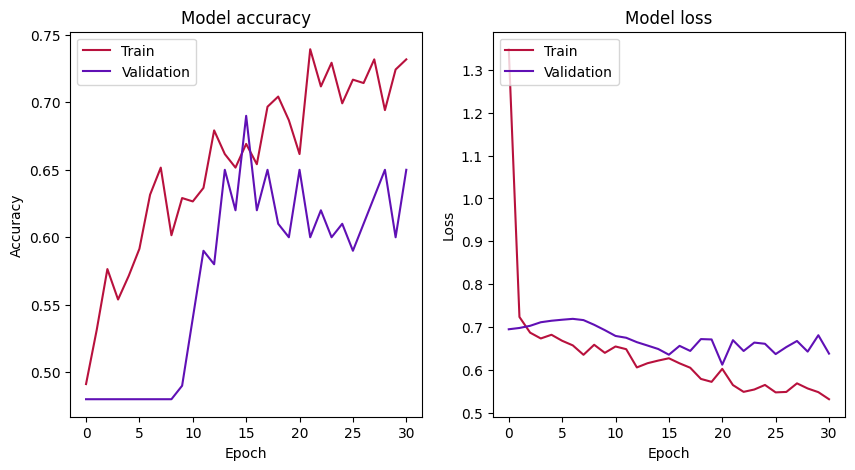

In [13]:
def plot_learning_curve(hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(hist.history['accuracy'], color='#b8113d')
    axs[0].plot(hist.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(hist.history['loss'], color='#b8113d')
    axs[1].plot(hist.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_learning_curve(hist[0])


In [14]:
x_test = []
y_test = []


for images, labels in validation_dataset:
    x_test.append(images.numpy())
    y_test.append(labels.numpy())


x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

4/4 [==============================] - 4s 101ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        48
           1       0.68      0.62      0.65        52

    accuracy                           0.65       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.65      0.65      0.65       100

Confusion Matrix:


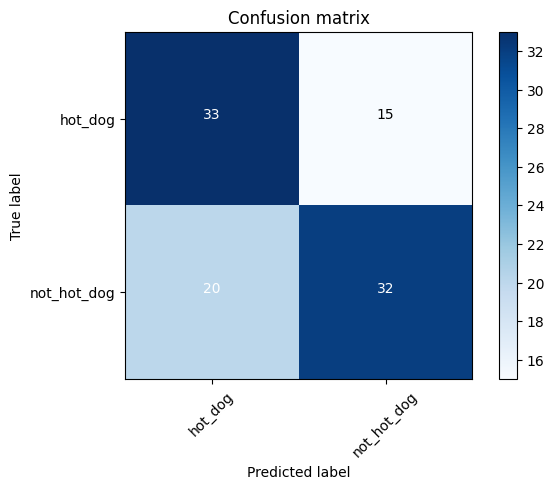

In [15]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Ця функція друкує та візуалізує матрицю невідповідностей з кольорами.
    `cm`: матриця невідповідностей
    `classes`: список назв класів для відображення на осях
    `title`: заголовок для матриці
    `cmap`: колірна схема для візуалізації
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Вивід значень у квадратах
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


predictions1 = model.predict(x_test)
predicted_classes1 = np.argmax(predictions1, axis=1)

cr1 = classification_report(y_test, predicted_classes1)
print("Classification Report:")
print(cr1)

cm1 = confusion_matrix(y_test, predicted_classes1)
print("Confusion Matrix:")
plot_confusion_matrix(cm1, class_names)

Freezed ResNet50

In [16]:
from tensorflow.keras.applications import ResNet50V2

In [17]:
class ResNetMy1(tf.keras.Model):
    def __init__(self, hidden_dim:int, n_classes:int, dropout_rate:float , name: str | None = None):
        super().__init__(name=name)

        global size
        self.feature_extractor = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights='imagenet',
            input_shape=(*size, 3),
        )
        self.feature_extractor.trainable = False
        self.pool=tf.keras.layers.GlobalMaxPooling2D()
        self.head = ClassificationHead(hidden_dim, n_classes,dropout_rate, name='head')

    def call(self, inputs, training: bool):
        x = self.feature_extractor(inputs)
        x = self.pool(x)
        x = self.head(x)
        return x

In [18]:
model1 = ResNetMy1(hidden_dim=100,n_classes=2,dropout_rate=0.1)

94668760/94668760 [==============================] - 3s 0us/step


In [19]:
model1.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4,weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    run_eagerly=True
)
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [20]:
start=time.time()
hist.append(model1.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=batch_size,
    #callbacks=[early_stopping1]
))
time_dict['Freezed resnet']=round(float(time.time()-start),2)

Epoch 1/50
25/25 [==============================] - 15s 438ms/step - loss: 32.7553 - accuracy: 0.4962 - val_loss: 13.7362 - val_accuracy: 0.5600
Epoch 2/50
25/25 [==============================] - 8s 305ms/step - loss: 18.8710 - accuracy: 0.5213 - val_loss: 9.2580 - val_accuracy: 0.5800
Epoch 3/50
25/25 [==============================] - 7s 290ms/step - loss: 16.2964 - accuracy: 0.5714 - val_loss: 10.1153 - val_accuracy: 0.5300
Epoch 4/50
25/25 [==============================] - 8s 289ms/step - loss: 14.8666 - accuracy: 0.5639 - val_loss: 9.7551 - val_accuracy: 0.5100
Epoch 5/50
25/25 [==============================] - 8s 306ms/step - loss: 12.2061 - accuracy: 0.5414 - val_loss: 9.5520 - val_accuracy: 0.5100
Epoch 6/50
25/25 [==============================] - 8s 307ms/step - loss: 10.3059 - accuracy: 0.5815 - val_loss: 6.7828 - val_accuracy: 0.5500
Epoch 7/50
25/25 [==============================] - 7s 275ms/step - loss: 9.6700 - accuracy: 0.5489 - val_loss: 8.2124 - val_accuracy: 0.49

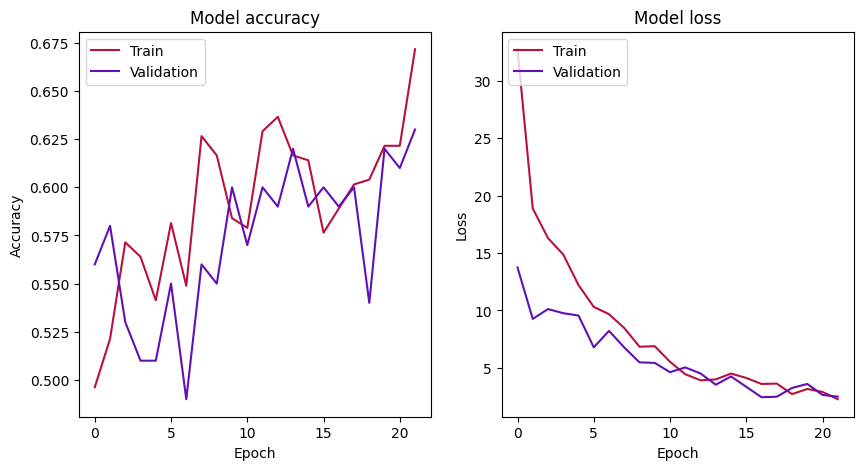

In [21]:
def plot_learning_curve(hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(hist.history['accuracy'], color='#b8113d')
    axs[0].plot(hist.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(hist.history['loss'], color='#b8113d')
    axs[1].plot(hist.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_learning_curve(hist[1])

4/4 [==============================] - 1s 113ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.58        48
           1       0.61      0.60      0.60        52

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100

Confusion Matrix:


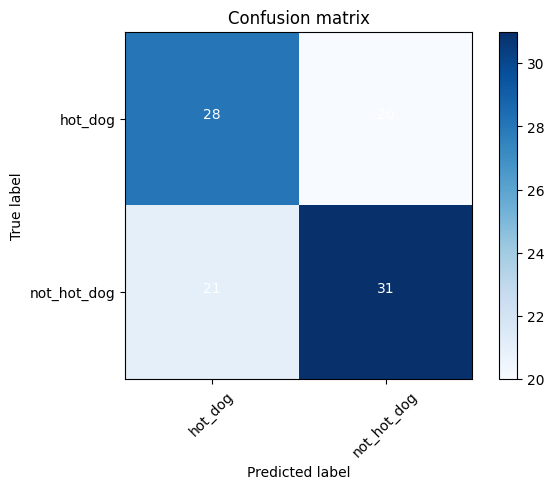

In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Ця функція друкує та візуалізує матрицю невідповідностей з кольорами.
    `cm`: матриця невідповідностей
    `classes`: список назв класів для відображення на осях
    `title`: заголовок для матриці
    `cmap`: колірна схема для візуалізації
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Вивід значень у квадратах
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


predictions1 = model1.predict(x_test)
predicted_classes1 = np.argmax(predictions1, axis=1)

cr1 = classification_report(y_test, predicted_classes1)
print("Classification Report:")
print(cr1)

cm1 = confusion_matrix(y_test, predicted_classes1)
print("Confusion Matrix:")
plot_confusion_matrix(cm1, class_names)

Unfreezed ResNet

In [23]:
class ResNetMy2(tf.keras.Model):
    def __init__(self, hidden_dim:int, n_classes:int, dropout_rate:float , name: str | None = None):
        super().__init__(name=name)

        global size
        self.feature_extractor = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights='imagenet',
            input_shape=(*size, 3),
        )
        self.feature_extractor.trainable = True
        self.pool=tf.keras.layers.GlobalMaxPooling2D()
        self.head = ClassificationHead(hidden_dim, n_classes,dropout_rate, name='head')

    def call(self, inputs, training: bool):
        x = self.feature_extractor(inputs)
        x = self.pool(x)
        x = self.head(x)
        return x

In [24]:
model2 = ResNetMy2(hidden_dim=100,n_classes=2,dropout_rate=0.1)

In [25]:
model2.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4,weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    run_eagerly=True
)
early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
start=time.time()
hist.append(model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=batch_size,
    #callbacks=[early_stopping1]
))
time_dict['Unfreezed resnet']=round(float(time.time()-start),2)

Epoch 1/50
25/25 [==============================] - 35s 617ms/step - loss: 1.1118 - accuracy: 0.6742 - val_loss: 0.8825 - val_accuracy: 0.6100
Epoch 2/50
25/25 [==============================] - 14s 552ms/step - loss: 0.2389 - accuracy: 0.9073 - val_loss: 0.7143 - val_accuracy: 0.7100
Epoch 3/50
25/25 [==============================] - 33s 1s/step - loss: 0.1425 - accuracy: 0.9398 - val_loss: 0.7342 - val_accuracy: 0.7500
Epoch 4/50
25/25 [==============================] - 14s 546ms/step - loss: 0.0749 - accuracy: 0.9749 - val_loss: 0.5801 - val_accuracy: 0.8200
Epoch 5/50
25/25 [==============================] - 14s 552ms/step - loss: 0.0617 - accuracy: 0.9749 - val_loss: 0.5157 - val_accuracy: 0.8500
Epoch 6/50
25/25 [==============================] - 15s 600ms/step - loss: 0.0414 - accuracy: 0.9900 - val_loss: 0.4843 - val_accuracy: 0.8600
Epoch 7/50
25/25 [==============================] - 14s 552ms/step - loss: 0.0112 - accuracy: 0.9975 - val_loss: 0.4579 - val_accuracy: 0.8300
Ep

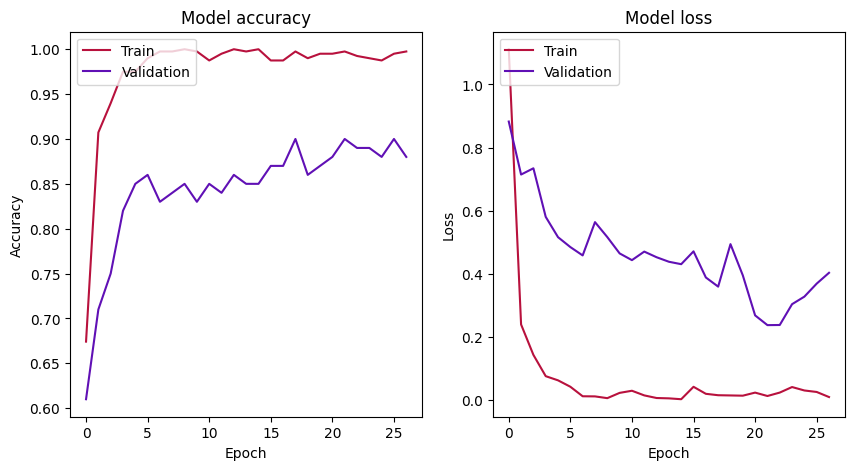

In [27]:
def plot_learning_curve(hist):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(hist.history['accuracy'], color='#b8113d')
    axs[0].plot(hist.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(hist.history['loss'], color='#b8113d')
    axs[1].plot(hist.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_learning_curve(hist[2])

4/4 [==============================] - 0s 116ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        48
           1       0.68      0.62      0.65        52

    accuracy                           0.65       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.65      0.65      0.65       100

Confusion Matrix:


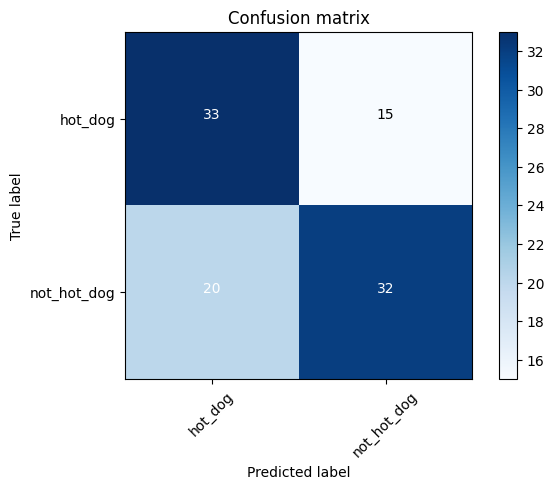

In [28]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Ця функція друкує та візуалізує матрицю невідповідностей з кольорами.
    `cm`: матриця невідповідностей
    `classes`: список назв класів для відображення на осях
    `title`: заголовок для матриці
    `cmap`: колірна схема для візуалізації
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Вивід значень у квадратах
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


predictions1 = model.predict(x_test)
predicted_classes1 = np.argmax(predictions1, axis=1)

cr1 = classification_report(y_test, predicted_classes1)
print("Classification Report:")
print(cr1)

cm1 = confusion_matrix(y_test, predicted_classes1)
print("Confusion Matrix:")
plot_confusion_matrix(cm1, class_names)

Comparing

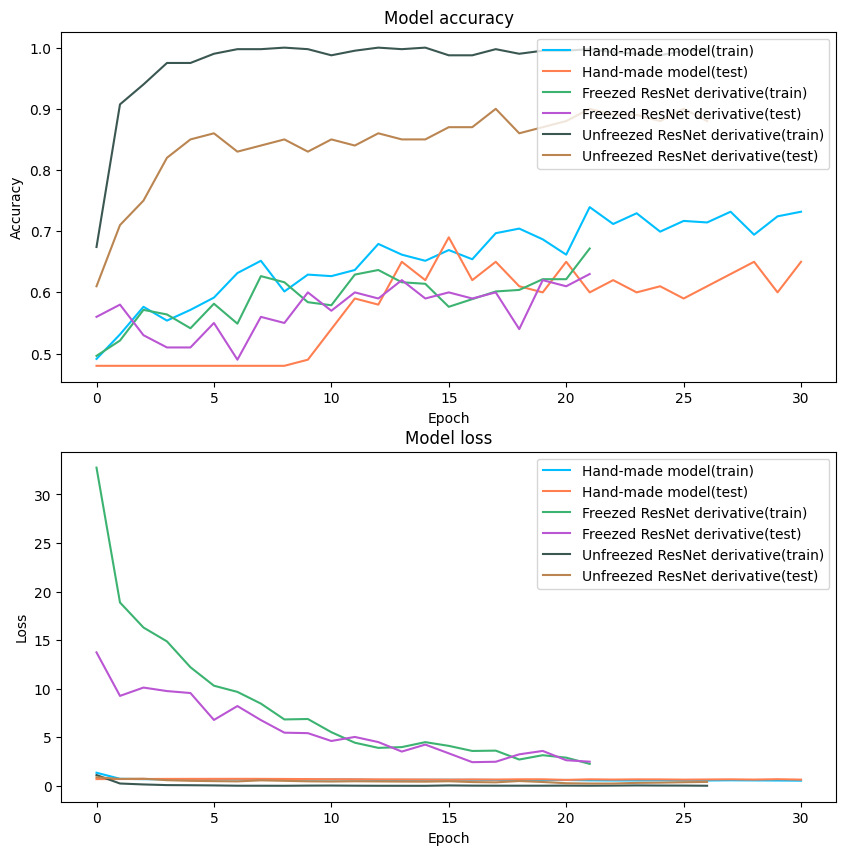

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

train_color = '#00bfff'
val_color = '#ff7f50'
train_color1 = '#3cb371'
val_color1 = '#ba55d3'
train_color2= '#3B5751'
val_color2 = '#BA8551'

axs[0].plot(hist[0].history['accuracy'], color=train_color,label=f'Hand-made model(train)')
axs[0].plot(hist[0].history['val_accuracy'], color=val_color,label=f'Hand-made model(test)')
axs[0].plot(hist[1].history['accuracy'], color=train_color1,label=f'Freezed ResNet derivative(train)')
axs[0].plot(hist[1].history['val_accuracy'], color=val_color1,label=f'Freezed ResNet derivative(test)')
axs[0].plot(hist[2].history['accuracy'], color=train_color2,label=f'Unfreezed ResNet derivative(train)')
axs[0].plot(hist[2].history['val_accuracy'], color=val_color2,label=f'Unfreezed ResNet derivative(test)')
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper right')


axs[1].plot(hist[0].history['loss'], color=train_color,label=f'Hand-made model(train)')
axs[1].plot(hist[0].history['val_loss'], color=val_color,label=f'Hand-made model(test)')
axs[1].plot(hist[1].history['loss'], color=train_color1,label=f'Freezed ResNet derivative(train)')
axs[1].plot(hist[1].history['val_loss'], color=val_color1,label=f'Freezed ResNet derivative(test)')
axs[1].plot(hist[2].history['loss'], color=train_color2,label=f'Unfreezed ResNet derivative(train)')
axs[1].plot(hist[2].history['val_loss'], color=val_color2,label=f'Unfreezed ResNet derivative(test)')
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

plt.show()

F1 and ROC-AUC

In [30]:
from sklearn.metrics import f1_score

y_pred1 = model.predict(x_test)
y_pred2 = model1.predict(x_test)
y_pred3 = model2.predict(x_test)


threshold = 0.5
y_pred_binary1 = (y_pred1 > threshold).astype(int)
y_pred_binary2 = (y_pred2 > threshold).astype(int)
y_pred_binary3 = (y_pred3 > threshold).astype(int)


y_pred_prob1 = y_pred1[:, 1]
y_pred_prob2 = y_pred2[:, 1]
y_pred_prob3 = y_pred3[:, 1]


y_test_binary = y_test[:]

roc_auc1 = roc_auc_score(y_test_binary, y_pred_prob1)
roc_auc2 = roc_auc_score(y_test_binary, y_pred_prob2)
roc_auc3 = roc_auc_score(y_test_binary, y_pred_prob3)

print(f"Model 1 - ROC-AUC: {roc_auc1}")
print(f"Model 2 - ROC-AUC: {roc_auc2}")
print(f"Model 3 - ROC-AUC: {roc_auc3}")

4/4 [==============================] - 0s 111ms/step
Model 1 - ROC-AUC: 0.717948717948718
Model 2 - ROC-AUC: 0.6430288461538461
Model 3 - ROC-AUC: 0.9711538461538461


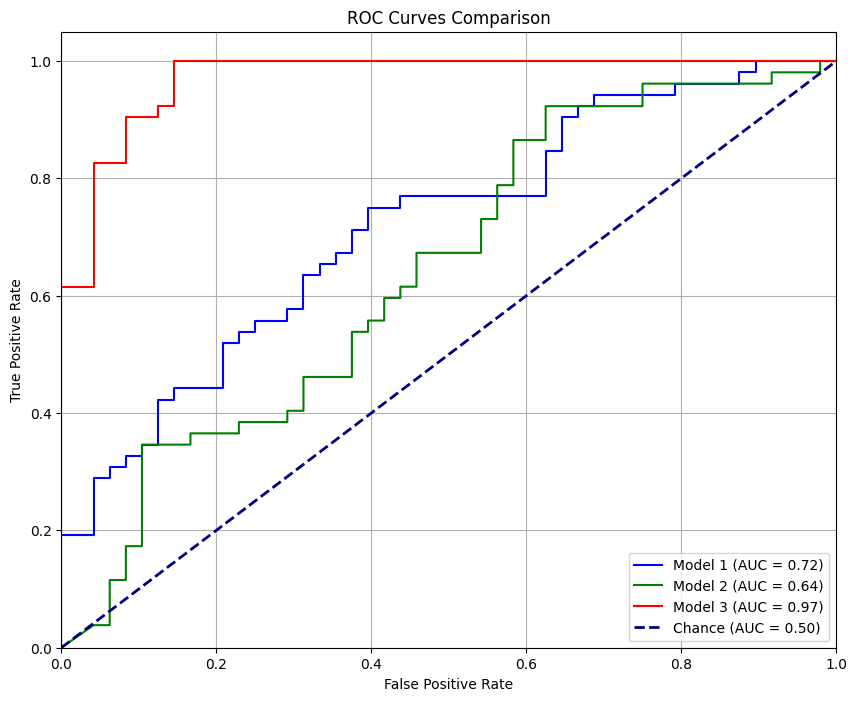

In [31]:
# Calculate true positive rates (TP) and false positive rates (FN) for each model
fpr1, tpr1, _ = roc_curve(y_test_binary, y_pred_prob1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_binary, y_pred_prob2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test_binary, y_pred_prob3)
roc_auc3 = auc(fpr3, tpr3)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='blue', label=f'Model 1 (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='green', label=f'Model 2 (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='red', label=f'Model 3 (AUC = {roc_auc3:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Time diff

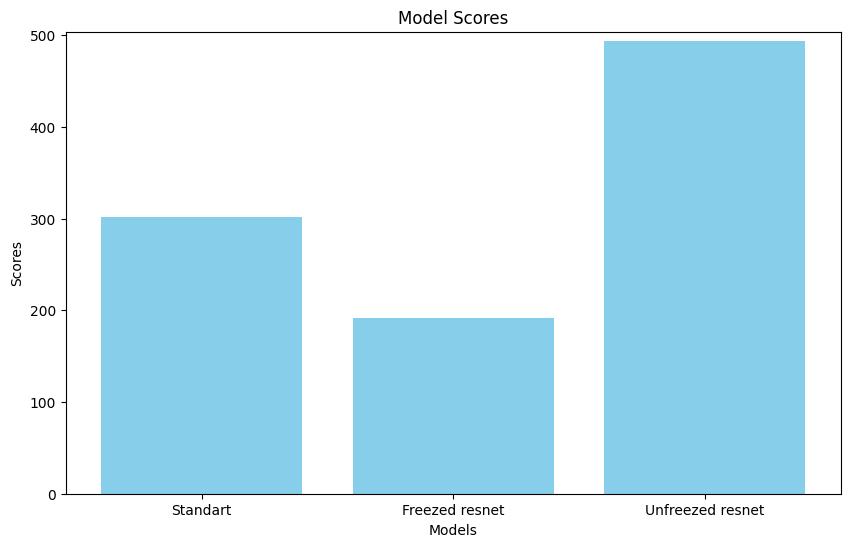

In [32]:
models = list(time_dict.keys())
scores = list(time_dict.values())


plt.figure(figsize=(10, 6))
plt.bar(models, scores, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Scores')
plt.xticks(models)
plt.ylim([0, max(scores) + 10])
plt.show()